# Import

In [1]:
# Basic
import pandas as pd
import numpy as np
import warnings

warnings.simplefilter('ignore')

# ML Toolkit
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score
from robusta.crossval import *

# Data
from sklearn.datasets import make_moons

# Model
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from robusta.semi_supervised import PseudoLabeling
from robusta.testing import get_estimator

# Plot
from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

jtplot.style('gruvboxd')
matplotlib.use('nbagg')

Using TensorFlow backend.


# Data

In [2]:
# Data
X, y = make_moons(1000, noise=0.1, random_state=0)

X = pd.DataFrame(X, columns=['x0', 'x1'])
y = pd.Series(y)

# Sort
index = abs(X.iloc[:,0]-0.5).sort_values(ascending=False).index
X = X.loc[index]
y = y.loc[index]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, shuffle=False)

<IPython.core.display.Javascript object>


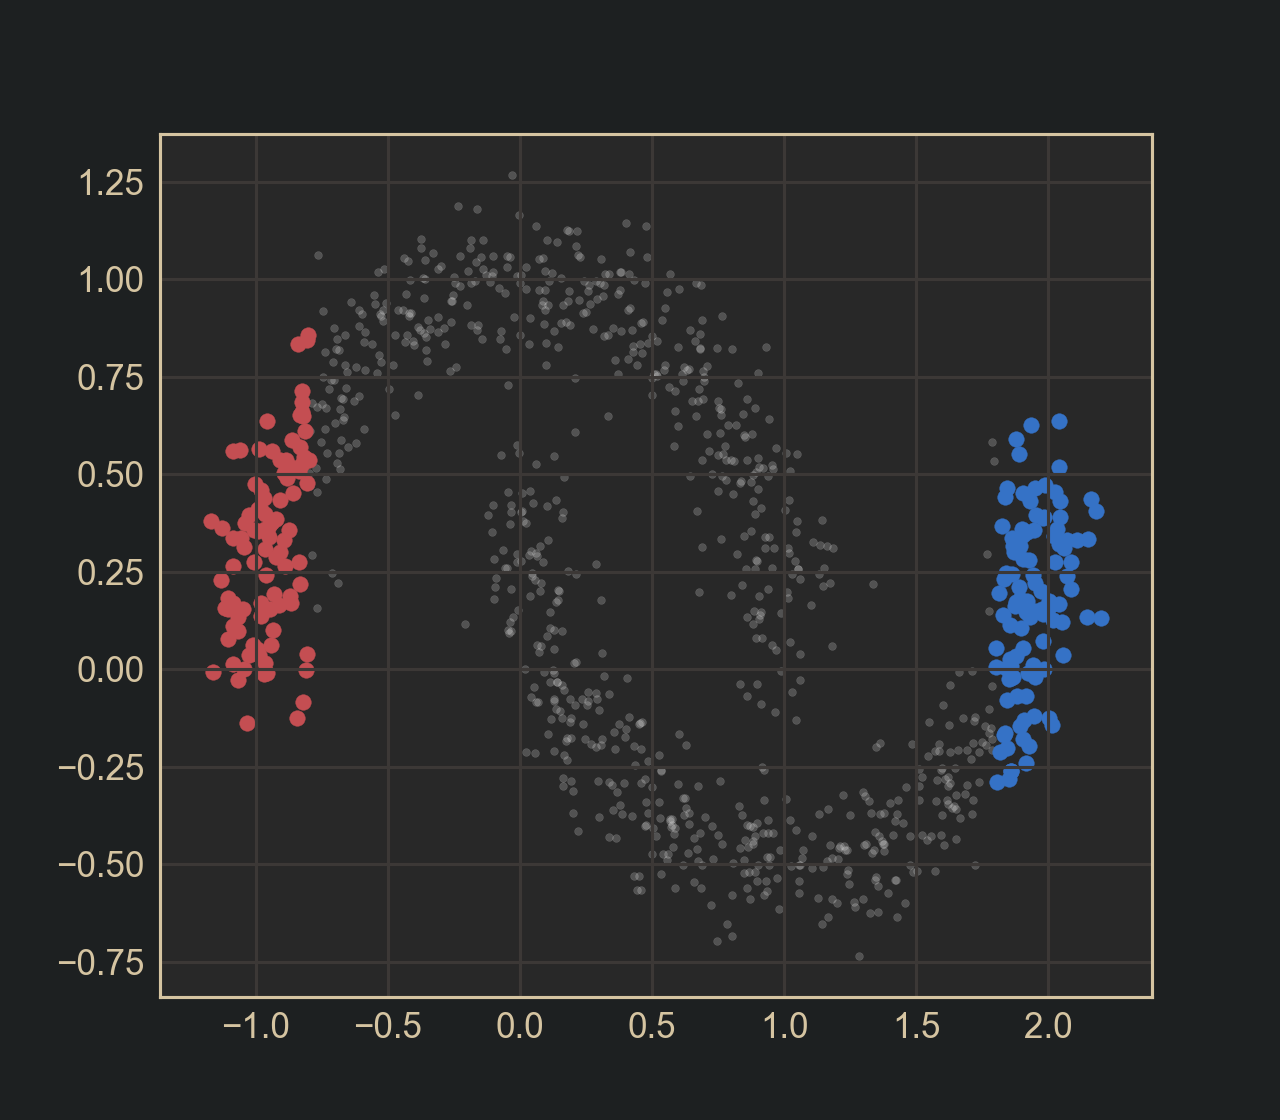

In [3]:
%matplotlib notebook

plt.scatter(X.iloc[:,0], X.iloc[:,1], marker='.', color='w', alpha=0.2)

X0 = X_train[y_train == 0]
plt.scatter(X0.iloc[:,0], X0.iloc[:,1], color='r', alpha=1)
plt.show()

X1 = X_train[y_train == 1]
plt.scatter(X1.iloc[:,0], X1.iloc[:,1], color='b', alpha=1)
plt.show()

# Plot

In [4]:
def plot_decision_function(clf, xlim=[0, 1], ylim=[0, 1], h=0.01, alpha=.8):
    
    xx, yy = np.meshgrid(np.arange(*xlim, h), np.arange(*ylim, h))
    zz = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    zz = zz.reshape(xx.shape)
    plt.contour(xx, yy, zz, alpha=alpha, linestyles=[':', '-', ':'],
                colors=['w', 'w', 'w'], levels=[-1., 0, 1.])
    plt.show()
    
    
def plot_proba(clf, xlim=[0, 1], ylim=[0, 1], h=0.01, alpha=.8, 
               probs=[.95, .99]):
    
    xx, yy = np.meshgrid(np.arange(*xlim, h), np.arange(*ylim, h))
    zz = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    
    for i in range(2):
        zz_ = zz[:,i].reshape(xx.shape)
        plt.contour(xx, yy, zz_, alpha=alpha, linestyles=['-.', '-'],
                    colors=['w', 'w'], levels=probs)
    plt.show()

In [5]:
def plot_classification(estimator, X, y, X_train, y_train, X_test, y_pred, X_=None, y_=None):
    
    # Train set
    X0 = X_train[y_train == 0]
    plt.scatter(X0.iloc[:,0], X0.iloc[:,1], color='r', alpha=1)
    plt.show()

    X1 = X_train[y_train == 1]
    plt.scatter(X1.iloc[:,0], X1.iloc[:,1], color='b', alpha=1)
    plt.show()

    # Predictions
    X0 = X_test[y_pred.iloc[:,0] > 0.5]
    plt.scatter(X0.iloc[:,0], X0.iloc[:,1], color='r', alpha=0.1)
    plt.show()

    X1 = X_test[y_pred.iloc[:,1] > 0.5]
    plt.scatter(X1.iloc[:,0], X1.iloc[:,1], color='b', alpha=0.1)
    plt.show()
    
    # Contour Plot
    xlim = [X.iloc[:,0].min(), X.iloc[:,0].max()]
    ylim = [X.iloc[:,1].min(), X.iloc[:,1].max()]
        
    if hasattr(estimator, 'decision_function'):
        plot_decision_function(estimator, xlim, ylim, alpha=0.2)
    
    if hasattr(estimator, 'predict_proba'):
        plot_proba(estimator, xlim, ylim, alpha=0.8)
    
    # Pseudo Labeling
    if X_ is not None and y_ is not None:
        
        X_ = pd.DataFrame(X_)
        y_ = pd.Series(y_)
    
        X0 = X_[y_ == 0]
        plt.scatter(X0.iloc[:,0], X0.iloc[:,1], marker='.', color='r')
        plt.show()

        X1 = X_[y_ == 1]
        plt.scatter(X1.iloc[:,0], X1.iloc[:,1], marker='.', color='b')
        plt.show()
        
    # Support vectors
    if hasattr(estimator, 'support_vectors_'):
        SV = estimator.support_vectors_
        plt.scatter(SV[:,0], SV[:,1], marker='.', color='w')
        plt.show()

# SVM

In [6]:
estimator = get_estimator('SVM', 'classifier', probability=True, gamma=10, C=0.5)

y_pred = estimator.fit(X_train, y_train).predict_proba(X_test)
y_pred = pd.DataFrame(y_pred, index=X_test.index)

ROC-AUC: 0.7192279565725572


<IPython.core.display.Javascript object>


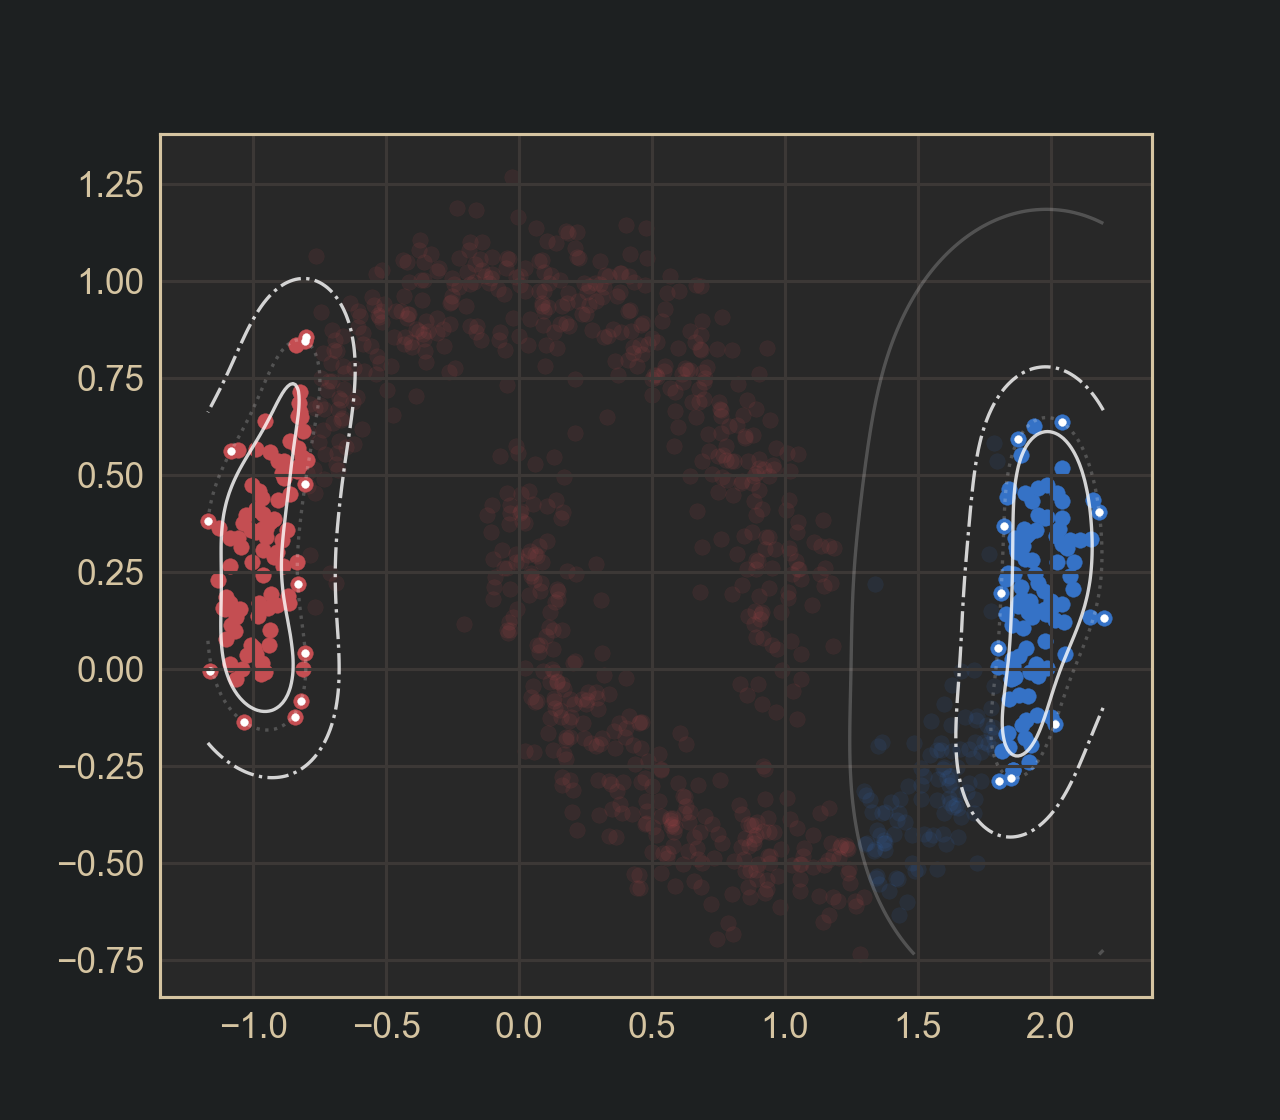

In [7]:
%matplotlib notebook

print('ROC-AUC:', roc_auc_score(y_test, y_pred.iloc[:,1]))
plot_classification(estimator, X, y, X_train, y_train, X_test, y_pred)

# SVM + Pseudo-Labeling

### 5 iterations

In [8]:
MAX_ITERS = 5

estimator = get_estimator('SVM', 'classifier', probability=True, gamma=30, C=0.1)
estimator = PseudoLabeling(estimator, verbose=1, proba=0.95, max_iter=MAX_ITERS)

y_pred = estimator.fit(X_train, y_train).predict_proba(X_test)
y_pred = pd.DataFrame(y_pred, index=X_test.index)

[20:53:29] ITER 2: Add 31 labels
[20:53:29] ITER 3: Add 30 labels
[20:53:29] ITER 4: Add 19 labels
[20:53:29] ITER 5: Add 30 labels


ROC-AUC: 0.7655305610940616


<IPython.core.display.Javascript object>


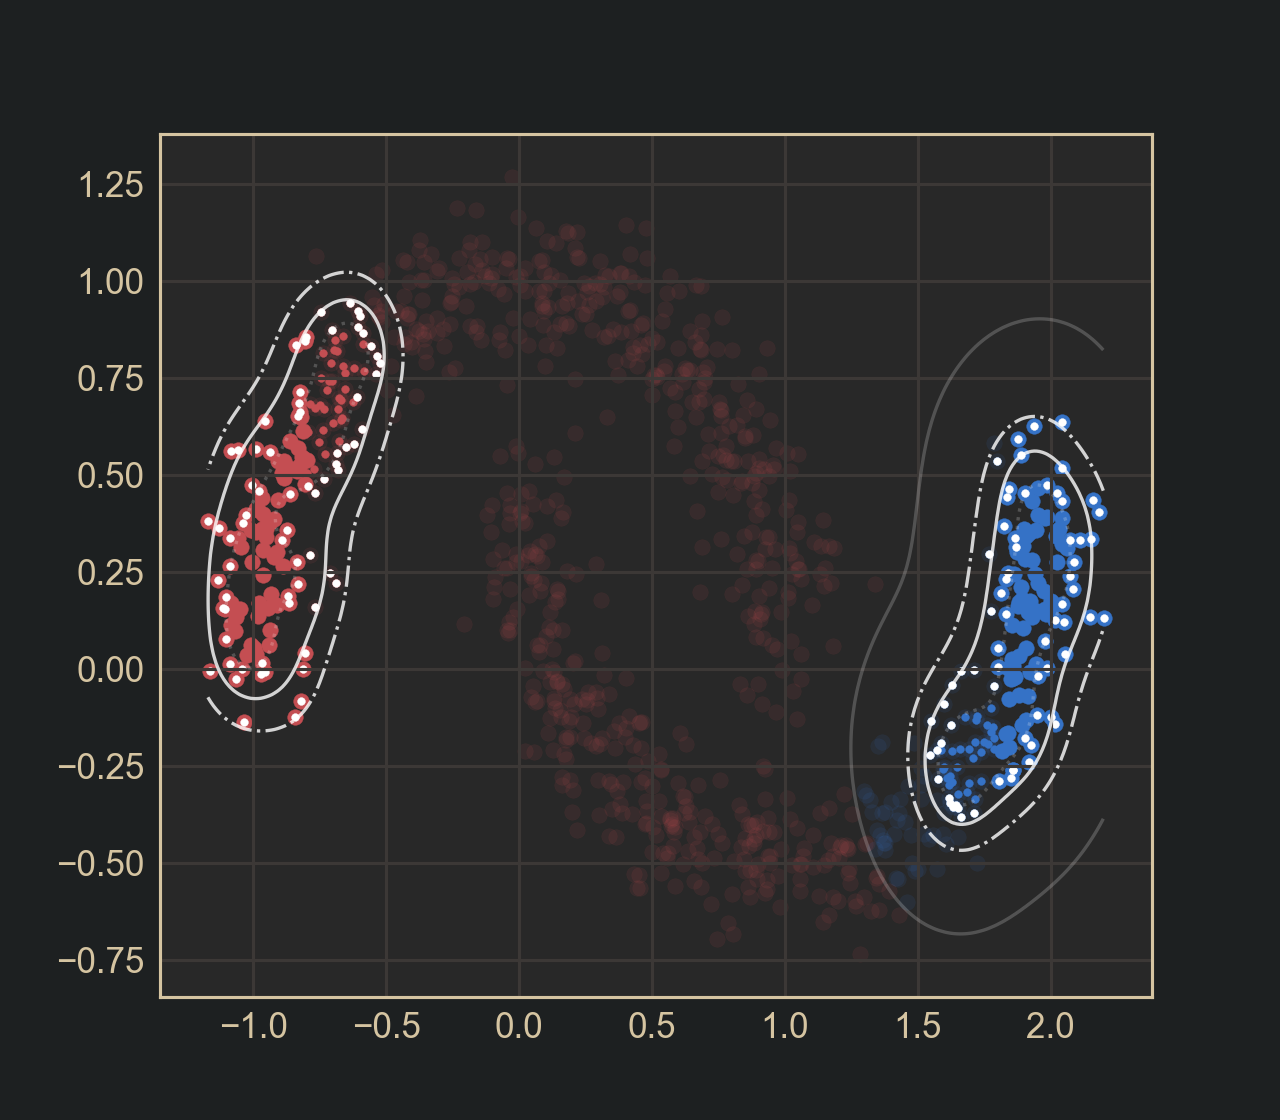

In [9]:
%matplotlib notebook

print('ROC-AUC:', roc_auc_score(y_test, y_pred.iloc[:,1]))
plot_classification(estimator.estimator_, X, y, X_train, y_train, 
                    X_test, y_pred, estimator.X_, estimator.y_)

### 10 iterations

In [10]:
MAX_ITERS = 10

estimator = get_estimator('SVM', 'classifier', probability=True, gamma=30, C=0.1)
estimator = PseudoLabeling(estimator, verbose=1, proba=0.95, max_iter=MAX_ITERS)

y_pred = estimator.fit(X_train, y_train).predict_proba(X_test)
y_pred = pd.DataFrame(y_pred, index=X_test.index)

[20:53:32] ITER 2: Add 32 labels
[20:53:32] ITER 3: Add 29 labels
[20:53:33] ITER 4: Add 20 labels
[20:53:33] ITER 5: Add 28 labels
[20:53:33] ITER 6: Add 24 labels
[20:53:33] ITER 7: Add 19 labels
[20:53:33] ITER 8: Add 25 labels
[20:53:33] ITER 9: Add 29 labels
[20:53:33] ITER 10: Add 23 labels


ROC-AUC: 0.8478351907294785


<IPython.core.display.Javascript object>


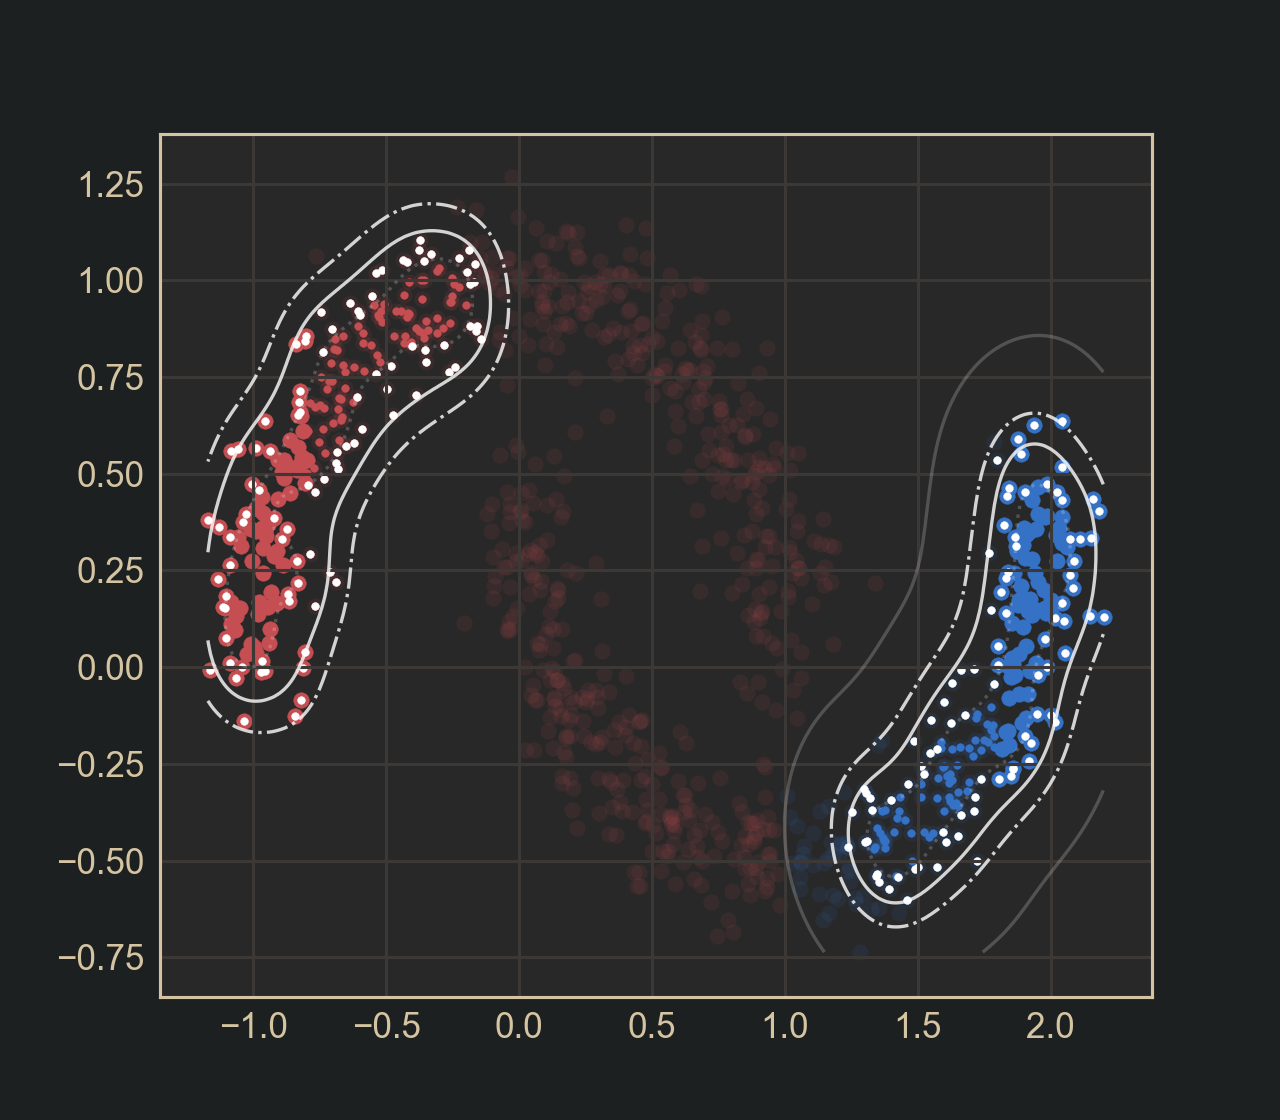

In [11]:
%matplotlib notebook

print('ROC-AUC:', roc_auc_score(y_test, y_pred.iloc[:,1]))
plot_classification(estimator.estimator_, X, y, X_train, y_train, 
                    X_test, y_pred, estimator.X_, estimator.y_)

### 20 iterations

In [12]:
MAX_ITERS = 20

estimator = get_estimator('SVM', 'classifier', probability=True, gamma=30, C=0.1)
estimator = PseudoLabeling(estimator, verbose=1, proba=0.95, max_iter=MAX_ITERS)

y_pred = estimator.fit(X_train, y_train).predict_proba(X_test)
y_pred = pd.DataFrame(y_pred, index=X_test.index)

[20:53:37] ITER 2: Add 32 labels
[20:53:37] ITER 3: Add 29 labels
[20:53:37] ITER 4: Add 19 labels
[20:53:37] ITER 5: Add 29 labels
[20:53:37] ITER 6: Add 22 labels
[20:53:37] ITER 7: Add 20 labels
[20:53:37] ITER 8: Add 25 labels
[20:53:37] ITER 9: Add 30 labels
[20:53:38] ITER 10: Add 23 labels
[20:53:38] ITER 11: Add 30 labels
[20:53:38] ITER 12: Add 26 labels
[20:53:38] ITER 13: Add 26 labels
[20:53:38] ITER 14: Add 23 labels
[20:53:38] ITER 15: Add 40 labels
[20:53:38] ITER 16: Add 24 labels
[20:53:38] ITER 17: Add 23 labels
[20:53:38] ITER 18: Add 31 labels
[20:53:38] ITER 19: Add 32 labels
[20:53:38] ITER 20: Add 31 labels


ROC-AUC: 0.9681857104462126


<IPython.core.display.Javascript object>


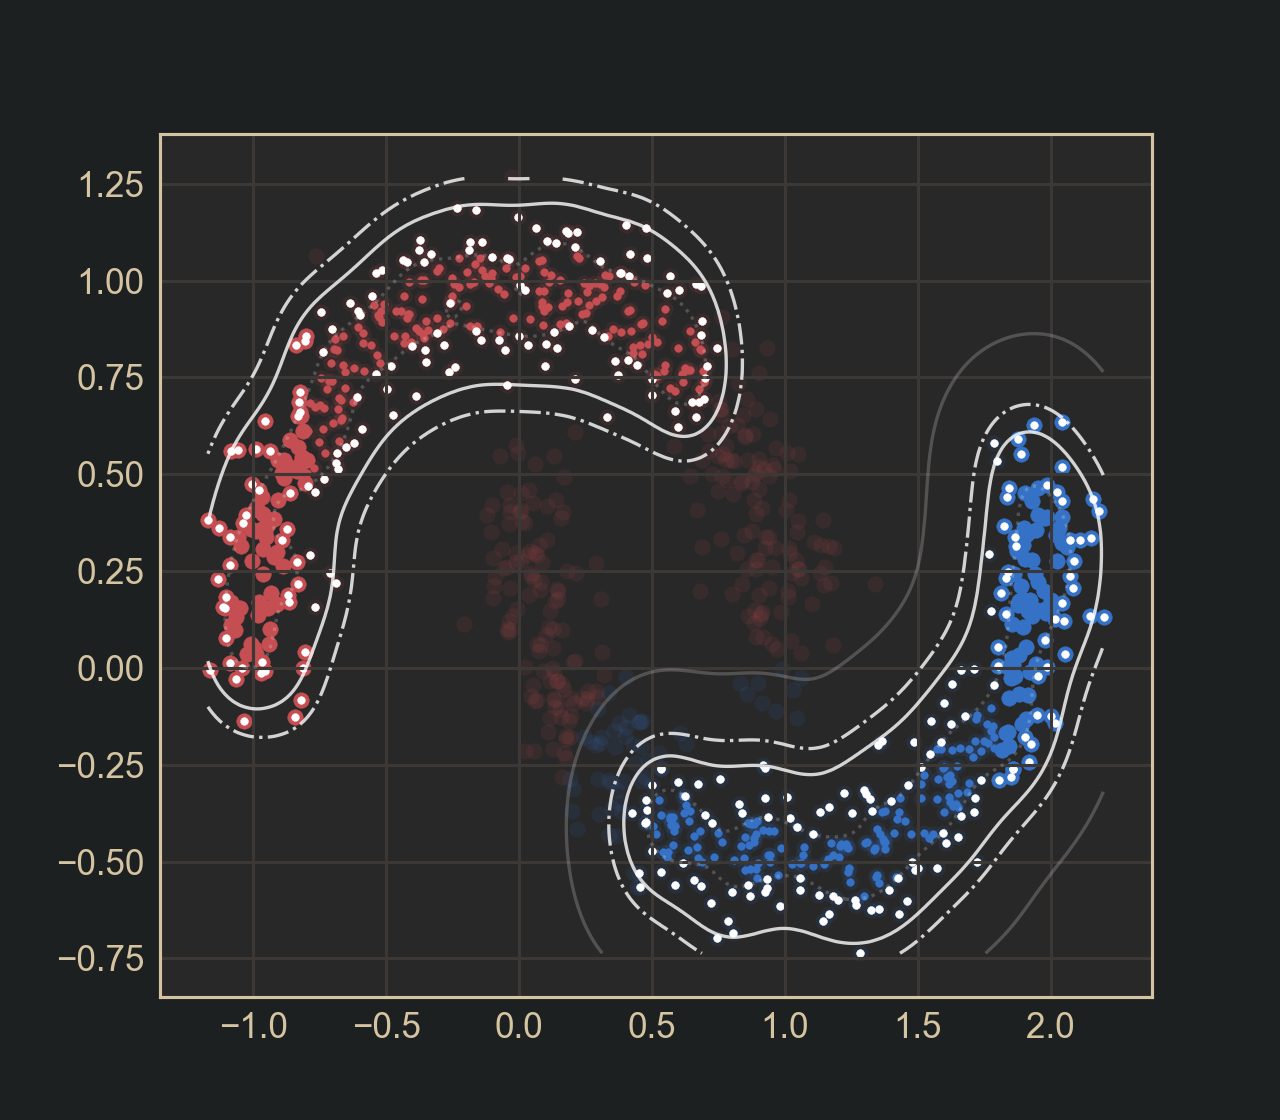

In [13]:
%matplotlib notebook

print('ROC-AUC:', roc_auc_score(y_test, y_pred.iloc[:,1]))
plot_classification(estimator.estimator_, X, y, X_train, y_train, 
                    X_test, y_pred, estimator.X_, estimator.y_)

### Maximum iterations

In [14]:
MAX_ITERS = None

estimator = get_estimator('SVM', 'classifier', probability=True, gamma=30, C=0.1)
estimator = PseudoLabeling(estimator, verbose=1, proba=0.95, max_iter=MAX_ITERS)

y_pred = estimator.fit(X_train, y_train).predict_proba(X_test)
y_pred = pd.DataFrame(y_pred, index=X_test.index)

[20:53:42] ITER 2: Add 32 labels
[20:53:42] ITER 3: Add 29 labels
[20:53:42] ITER 4: Add 18 labels
[20:53:42] ITER 5: Add 29 labels
[20:53:43] ITER 6: Add 23 labels
[20:53:43] ITER 7: Add 22 labels
[20:53:43] ITER 8: Add 25 labels
[20:53:43] ITER 9: Add 31 labels
[20:53:43] ITER 10: Add 23 labels
[20:53:43] ITER 11: Add 32 labels
[20:53:43] ITER 12: Add 21 labels
[20:53:43] ITER 13: Add 26 labels
[20:53:43] ITER 14: Add 23 labels
[20:53:43] ITER 15: Add 40 labels
[20:53:43] ITER 16: Add 23 labels
[20:53:44] ITER 17: Add 20 labels
[20:53:44] ITER 18: Add 28 labels
[20:53:44] ITER 19: Add 35 labels
[20:53:44] ITER 20: Add 32 labels
[20:53:44] ITER 21: Add 27 labels
[20:53:44] ITER 22: Add 34 labels
[20:53:44] ITER 23: Add 29 labels
[20:53:44] ITER 24: Add 26 labels
[20:53:44] ITER 25: Add 41 labels
[20:53:44] ITER 26: Add 37 labels
[20:53:44] ITER 27: Add 23 labels
[20:53:45] ITER 28: Add 13 labels
[20:53:45] ITER 29: Add 20 labels
[20:53:45] ITER 30: Add 14 labels
[20:53:45] ITER 31: Ad

ROC-AUC: 0.999931246132595


<IPython.core.display.Javascript object>


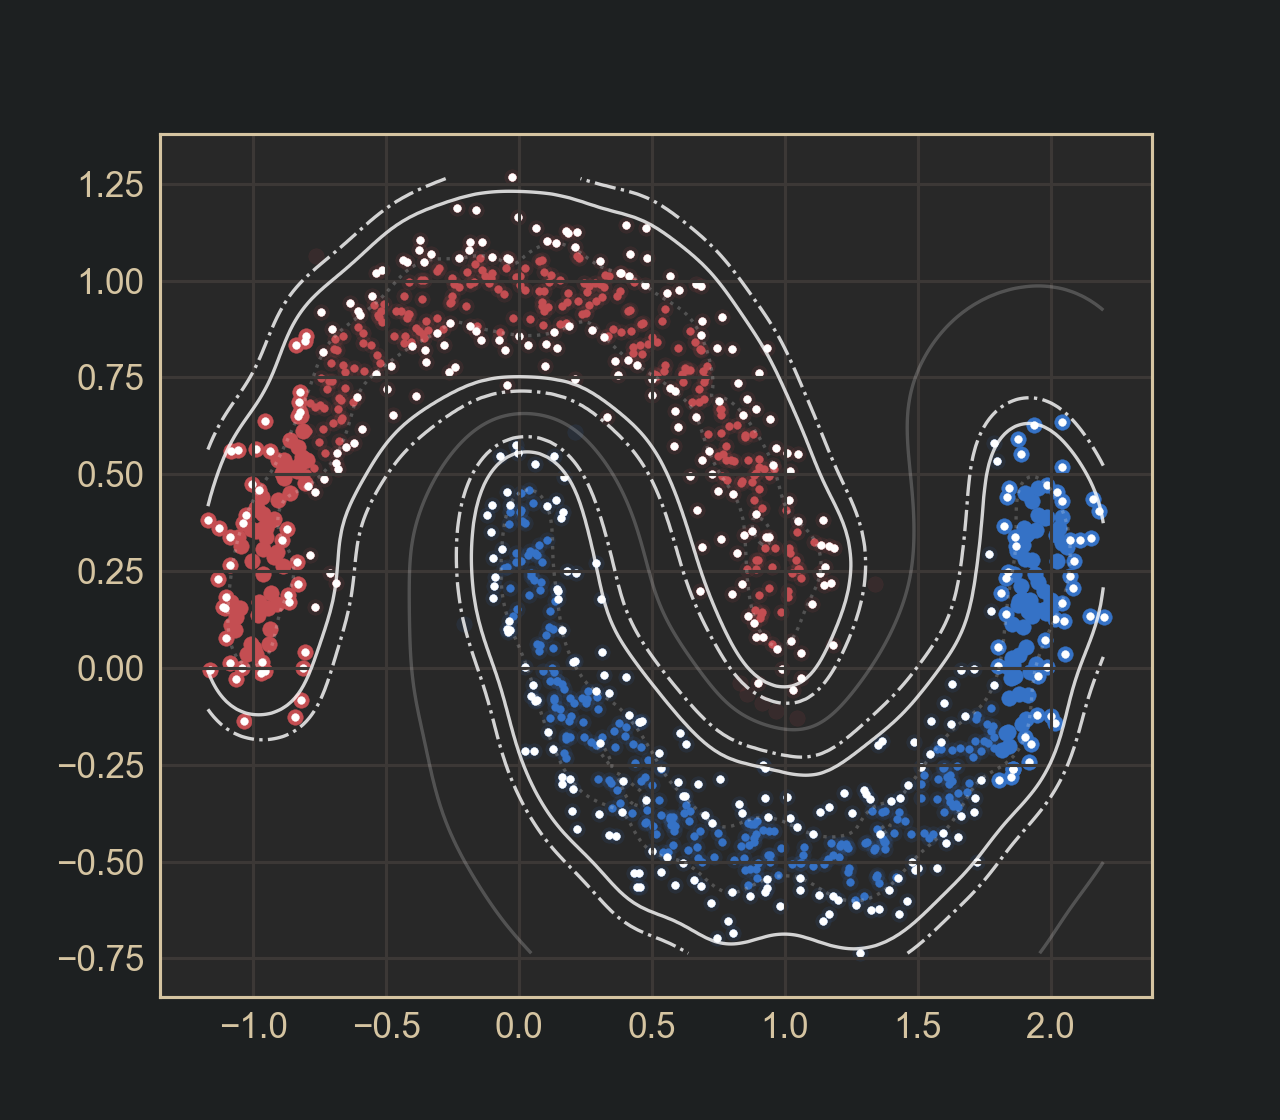

In [15]:
%matplotlib notebook

print('ROC-AUC:', roc_auc_score(y_test, y_pred.iloc[:,1]))
plot_classification(estimator.estimator_, X, y, X_train, y_train, 
                    X_test, y_pred, estimator.X_, estimator.y_)

# Scikit-Learn: LabelPropagation

In [17]:
estimator = LabelPropagation(gamma=30, max_iter=10000) 

y_test_ = y_test.map({0: -1, 1: -1})

X_train_test = pd.concat([X_train, X_test])
y_train_test = pd.concat([y_train, y_test_])

y_pred = estimator.fit(X_train_test, y_train_test).predict_proba(X_test)
y_pred = pd.DataFrame(y_pred, index=X_test.index)

ROC-AUC: 0.9988374346056965


<IPython.core.display.Javascript object>


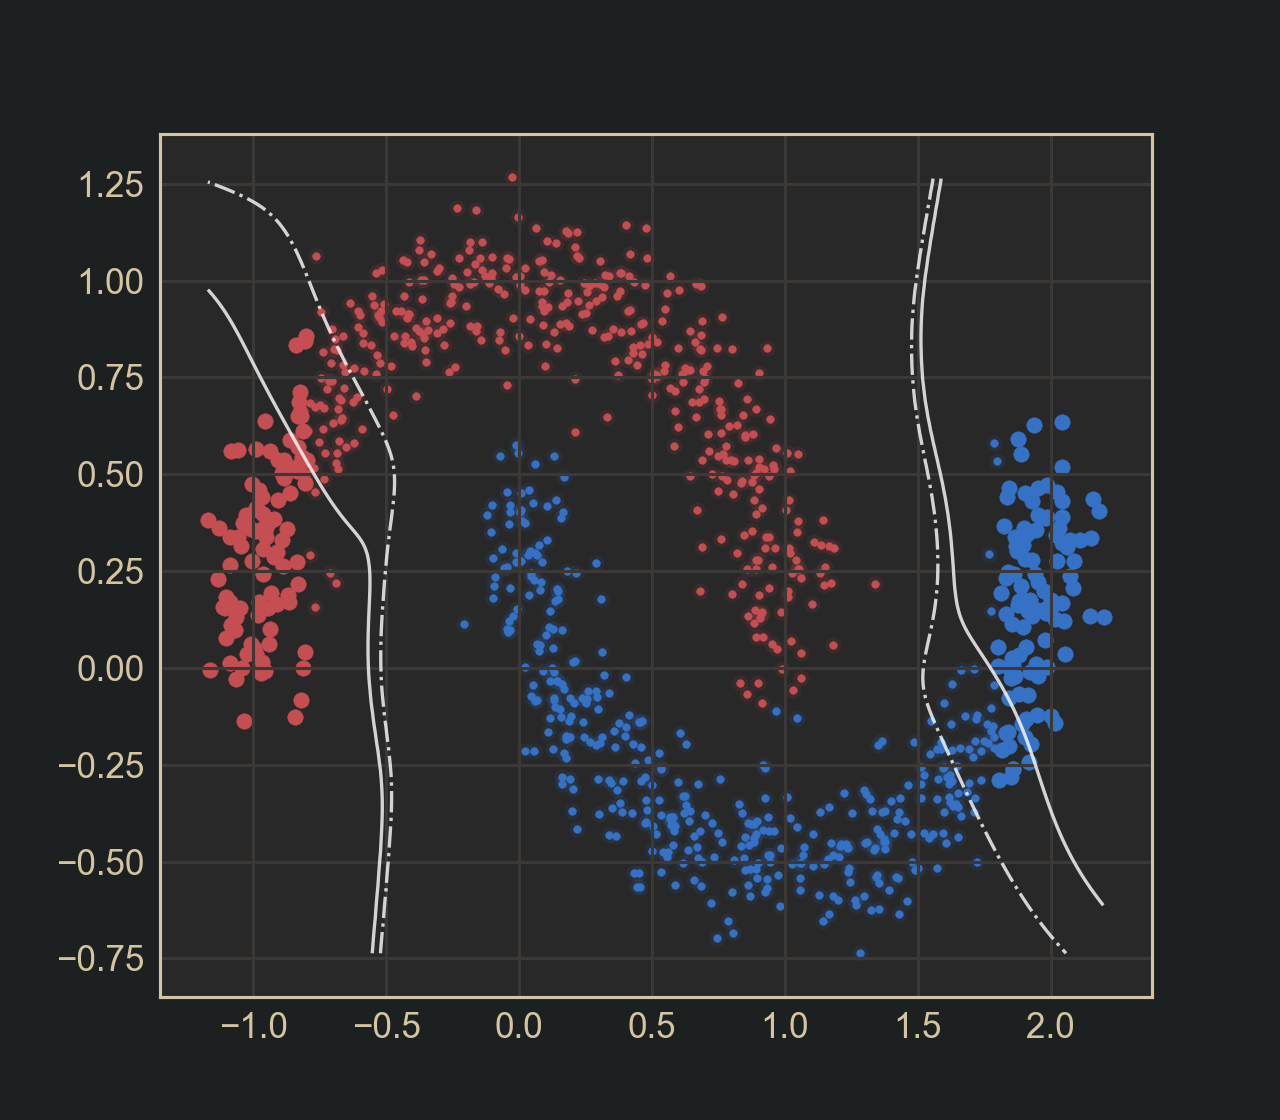

In [18]:
%matplotlib notebook

print('ROC-AUC:', roc_auc_score(y_test, y_pred.iloc[:,1]))
plot_classification(estimator, X, y, X_train, y_train, 
                    X_test, y_pred, estimator.X_, estimator.transduction_)

# Scikit-Learn: LabelSpreading

In [26]:
estimator = LabelSpreading(gamma=20, alpha=0.99, max_iter=10000) 

y_test_ = y_test.map({0: -1, 1: -1})

X_train_test = pd.concat([X_train, X_test])
y_train_test = pd.concat([y_train, y_test_])

y_pred = estimator.fit(X_train_test, y_train_test).predict_proba(X_test)
y_pred = pd.DataFrame(y_pred, index=X_test.index)

ROC-AUC: 0.9950184697889257


<IPython.core.display.Javascript object>


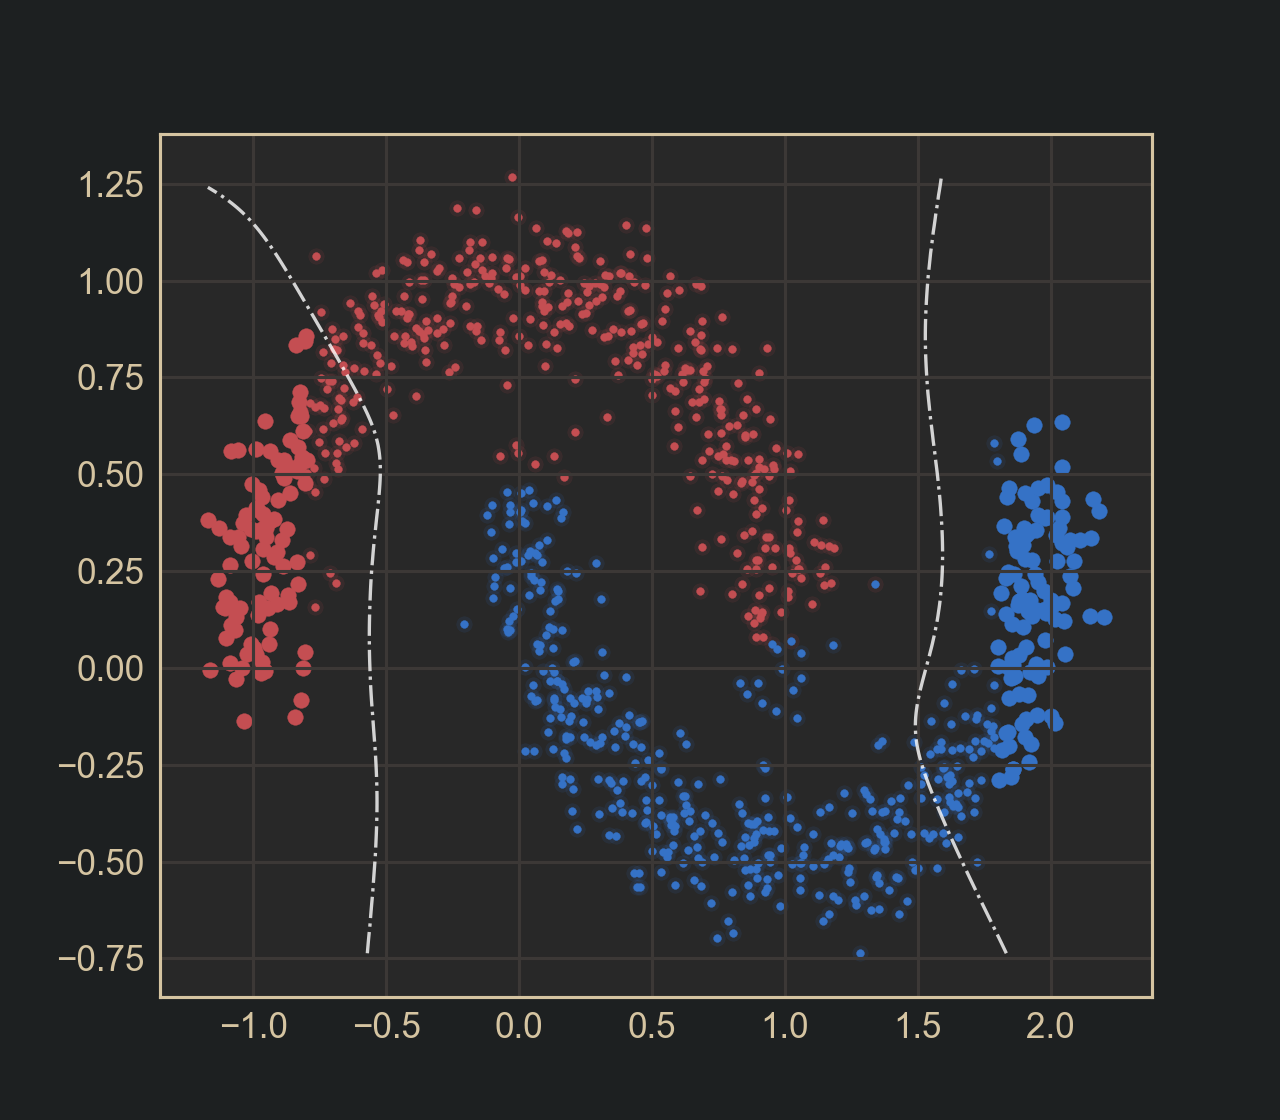

In [27]:
%matplotlib notebook

print('ROC-AUC:', roc_auc_score(y_test, y_pred.iloc[:,1]))
plot_classification(estimator, X, y, X_train, y_train, 
                    X_test, y_pred, estimator.X_, estimator.transduction_)